In the following notebook, we will train a regressor to predict a movies average rating using [IMDb datasets](https://www.imdb.com/interfaces/). First we import the dataset `title.ratings.tsv.gz`, `title.basics.tsv.gz` because they contain the target value *averageRating* and some basic information about the dataset, respectively.

In [10]:
import pandas as pd

ratings = pd.read_csv('title.ratings.tsv.gz',sep='\t', compression='gzip')
ratings.head(3)

,tconst,averageRating,numVotes
0,tt0000001,5.8,1417
1,tt0000002,6.4,167
2,tt0000003,6.6,1013


In [46]:
basics = pd.read_csv('title.basics.tsv.gz',sep='\t', compression='gzip', low_memory=False)
basics.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


According to the *titleType*, the dataset also contains audio-visual material except from movies. 

In [12]:
basics.titleType.unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvEpisode', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

However, we want to focus at real movies right now. Therefore, we remove all rows that do not describe a movie like videos and tv series by filtering the title type. Then we drop the columns *primaryTitle*, *originalTitle* and *endYear*, because I do not see any easily accessible predictive value in the titles and *endYear* is '\N' for all movies. The column titleType will also be dropped because the remaining titles are movies anyways.

In [13]:
basics = basics.query('titleType == "movie"')
basics = basics.drop(columns=['primaryTitle', 'originalTitle', 'endYear', 'titleType'])
basics.head(3)

,tconst,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,0,1894,45,Romance
145,tt0000147,0,1897,20,"Documentary,News,Sport"
332,tt0000335,0,1900,\N,"Biography,Drama"


In [14]:
print('Dataset total entries: {}'.format(basics.shape[0]))
print('---')
print('Numeric runtime entries: {}'.format(basics[pd.to_numeric(basics["runtimeMinutes"], errors='coerce').notnull()].shape[0]))
print('Missing/invalid runtime entries: {}'.format(basics[pd.to_numeric(basics["runtimeMinutes"], errors='coerce').isnull()].shape[0]))
print('---')
print('Numeric startYear entries: {}'.format(basics[pd.to_numeric(basics["startYear"], errors='coerce').notnull()].shape[0]))
print('Missing/invalid startYear entries: {}'.format(basics[pd.to_numeric(basics["startYear"], errors='coerce').isnull()].shape[0]))
print('---')
print('Numeric isAdult entries: {}'.format(basics.query('isAdult==0 or isAdult==1').shape[0]))
print('Missing/invalid isAdult entries: {}'.format(basics.query('isAdult!=0 and isAdult!=1').shape[0]))

Dataset total entries: 499586
---
Numeric runtime entries: 312650
Missing/invalid runtime entries: 186936
---
Numeric startYear entries: 452853
Missing/invalid startYear entries: 46733
---
Numeric isAdult entries: 499586
Missing/invalid isAdult entries: 0


The columns *runtimeMinutes* and *startYear* contain null values and errors. I speculate that the wrong and missing values are biased. I guess that old and especially unpopular movies are more likely to contain missing values/errors.
Therefore, I assume that a missing/erroneous value has a high predictive value for this particular dataset, but does not generalize well to the prediction of new, unrated movies. This, however, is just an assumption that has to be checked and might lead to better results to find a sensible ways to fill the values.

Given the time limitation, we just remove all the rows that do not contain numeric values because there are still a lot of remaining movies.

In [15]:
basics = basics[pd.to_numeric(basics["runtimeMinutes"], errors='coerce').notnull()]
basics["runtimeMinutes"] = pd.to_numeric(basics["runtimeMinutes"])

basics = basics[pd.to_numeric(basics["startYear"], errors='coerce').notnull()]
basics["startYear"] = pd.to_numeric(basics["startYear"])

The column *genres* contains up to three genres for each movie. Some genres might lead to a better rating than others. Therefore, we create a new column for each genre and encode it similar to one hot encoding. Another possible approach, would be, to look at the combination of genres as well. 

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
basics['genres'] = basics['genres'].apply(lambda genreString: genreString.split(","))

mlb = MultiLabelBinarizer()
encoded_genres = pd.DataFrame(mlb.fit_transform(basics['genres']), columns=mlb.classes_, index=basics.index)

basics = pd.concat([basics,encoded_genres], axis=1)
basics = basics.drop(columns=['genres','\\N'])

basics.head(3)

,tconst,isAdult,startYear,runtimeMinutes,Action,Adult,Adventure,Animation,Biography,Comedy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
8,tt0000009,0,1894,45,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
145,tt0000147,0,1897,20,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
499,tt0000502,0,1905,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We finished preprocessing the basics dataset for now. Next, we will prepare the ratings dataset and create our first model. 

The number of votes for a movie probably has a high predictive value because I assume that popular movies are more likely to receive votes. However, it is more of a target value than a feature. At the time that we know the number of votes, we most likely also know the movie rating. Therefore, we remove the column even though it might lower the models performance on the training data.

In [17]:
ratings = ratings.drop(columns=['numVotes'])
ratings.head(3)

,tconst,averageRating
0,tt0000001,5.8
1,tt0000002,6.4
2,tt0000003,6.6


Then we merge the basics and ratings datasets by performing an inner join on the movie identifier 'tconst'.

In [19]:
prep_basics_ratings = pd.merge(basics, ratings, on='tconst')
prep_basics_ratings.head(3)

,tconst,isAdult,startYear,runtimeMinutes,Action,Adult,Adventure,Animation,Biography,Comedy,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,averageRating
0,tt0000009,0,1894,45,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5.5
1,tt0000147,0,1897,20,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.2
2,tt0000574,0,1906,70,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6.3


In the following, we just preprocess the data to be compatible with our model generation algorithm. We remove tconst because we it has no predictive value and was only used to join the datasets.

In [21]:
import numpy as np

target = np.array(prep_basics_ratings['averageRating'])

features_df = prep_basics_ratings.drop(columns=['tconst','averageRating'])
# Keep feature names for possible later use.
feature_names = list(features_df.columns)
features = np.array(features_df)

To test the performance of our model later on, we seperate our training data into training and testing data.

In [23]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.20, random_state = 1)

We will first use a random forest regressor to generate our model. The number of trees (n_estimators) is limited by my memory and processing power. In general, however, more trees improve the result.

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 120, random_state = 2)
rf.fit(train_features, train_target);

To measure the performance of the resulting model, we predict our test features and measure the mean absolute error.

In [14]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_target)

print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.95


The next question that comes to mind is whether a 0.95 mean absolute error is a good result.
Let's look at the mean absolute error of always predicting the average of all average ratings.

In [15]:
averageRatingMean = np.mean(train_target)
print('Mean Absolute Error:', round(np.mean(abs(test_target-averageRatingMean)), 2))

Mean Absolute Error: 1.03


Our model reduces the mean average error by 0.08 or 7.8% compared to prediciting the average according to the mean absolute error. When assuming a uniform distribution of the ratings from 1.0 to 10.0, prediciting the average would result into a mean average error of: 

In [34]:
(10-1)/2/2

2.25

The histogram below shows a way smaller variance than a uniform distribution. Therefore, predicting the mean works better than expected.

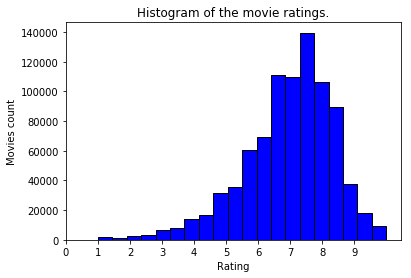

In [32]:
# Import the libraries
import matplotlib.pyplot as plt

# matplotlib histogram
plt.hist(ratings['averageRating'], color = 'blue', edgecolor = 'black',
         bins = 20)

# Add labels
plt.title('Histogram of the movie ratings.')
plt.xlabel('Rating')
plt.xticks(range(10))
plt.ylabel('Movies count')

plt.show()

The random forest regressor allows us to retrieve the relative importance of each feature for the final result.
It looks like most of the genres have a neglectable impact on the prediction. The importances could be used to drop some of the features. However, we will keep them for now.

In [39]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

runtimeMinutes       Importance: 0.29
startYear            Importance: 0.26
Documentary          Importance: 0.13
Horror               Importance: 0.06
Drama                Importance: 0.03
Adventure            Importance: 0.02
Comedy               Importance: 0.02
Crime                Importance: 0.02
Romance              Importance: 0.02
Thriller             Importance: 0.02
Action               Importance: 0.01
Animation            Importance: 0.01
Biography            Importance: 0.01
Family               Importance: 0.01
Fantasy              Importance: 0.01
History              Importance: 0.01
Music                Importance: 0.01
Musical              Importance: 0.01
Mystery              Importance: 0.01
Sci-Fi               Importance: 0.01
Sport                Importance: 0.01
War                  Importance: 0.01
Western              Importance: 0.01
isAdult              Importance: 0.0
Adult                Importance: 0.0
Film-Noir            Importance: 0.0
Game-Show      

To further improve our model, we look at the remaining unused datasets. `title.crew.tsv.gz` contains information about the directors and writers of a movie. This information should have a high predictive value. 

First, we import the dataset. Then, we transform the directors column back to an array of director identifiers.

In [40]:
crew = pd.read_csv('title.crew.tsv.gz',sep='\t', compression='gzip')
crew['directors'] = crew['directors'].apply(lambda directors: directors.split(","))
crew.head(3)

,tconst,directors,writers
0,tt0000001,[nm0005690],\N
1,tt0000002,[nm0721526],\N
2,tt0000003,[nm0721526],\N


In [41]:
print('Dataset entries: {}'.format(crew.shape[0]))

Dataset entries: 5317248


Given the huge amount of different directors, one hot encoding would lead to a massive dataset. Therefore, we try to measure the impact of the director in another way. We assume that, in general, a director who produces more movies produces movies with a higher rating because he receives more job offers. Therefore, we count how many movies each director produced.

In [42]:
director_count = {}

def add_director_count(directors):
    for director in directors:
        # dirty solution
        if director in director_count:
            director_count[director] = director_count[director] + 1
        else:
            director_count[director] = 1
                
crew['directors'].apply(add_director_count);
            
director_count.pop('\\N');
director_count;

Then, we introduce a new feature *director_movie_count*. The same procedure could be done for the *writers*. We leave it out right now because it works accordingly.

In [47]:
def directors_to_count(directors):
    max = 0
    for director in directors:
        if director_count.get(director, 0) > max:
            max = director_count[director]
    return max

crew['directors_movie_count'] = crew['directors'].apply(directors_to_count)
crew.head(3)

,tconst,directors,writers,directors_movie_count
0,tt0000001,[nm0005690],\N,163
1,tt0000002,[nm0721526],\N,7
2,tt0000003,[nm0721526],\N,7


Then we remove the *directors* and *writers* column and perform an inner join with the previously preprocessed dataset.

In [49]:
director_movie_count = crew.drop(columns=['directors','writers'])
prep_basics_directors_ratings = pd.merge(prep_basics_ratings, director_movie_count, on='tconst')

prep_basics_directors_ratings.head(3)

,tconst,isAdult,startYear,runtimeMinutes,Action,Adult,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,averageRating,directors_movie_count
0,tt0000009,0,1894,45,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,5.5,1
1,tt0000147,0,1897,20,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,5.2,2
2,tt0000574,0,1906,70,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6.3,1


Then we train our model again.

In [50]:
target = np.array(trainingSet['averageRating'])

features_df = prep_basics_directors_ratings.drop(columns=['tconst','averageRating'])#, 'Adult', 'isAdult', 'Animation', 'Film-Noir', 'Game-Show', 'News', 'Reality-TV', 'Short', 'Sport', 'Talk-Show', 'Western'])
feature_names = list(features_df.columns)
features = np.array(features_df)

In [51]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.20, random_state = 1)

In [52]:
rf = RandomForestRegressor(n_estimators = 120, random_state = 2)
rf.fit(train_features, train_target);

The new feature *directors_movie_count* indeed improved our model. According to the feature importance measurement, it is one of our best features so far.

In [53]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_target)

print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.92


In [55]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

runtimeMinutes       Importance: 0.23
directors_movie_count Importance: 0.22
startYear            Importance: 0.21
Documentary          Importance: 0.1
Horror               Importance: 0.04
Drama                Importance: 0.03
Comedy               Importance: 0.02
Action               Importance: 0.01
Adventure            Importance: 0.01
Biography            Importance: 0.01
Crime                Importance: 0.01
Family               Importance: 0.01
Fantasy              Importance: 0.01
History              Importance: 0.01
Music                Importance: 0.01
Musical              Importance: 0.01
Mystery              Importance: 0.01
Romance              Importance: 0.01
Sci-Fi               Importance: 0.01
Thriller             Importance: 0.01
War                  Importance: 0.01
isAdult              Importance: 0.0
Adult                Importance: 0.0
Animation            Importance: 0.0
Film-Noir            Importance: 0.0
Game-Show            Importance: 0.0
News             

To further improve our model, we will utilize the `title.akas.tsv.gz` dataset. It contains information about the titles of a movie in different regions of the world. There are different interesting features we can build from this dataset. For example, using the original region of the movie as a feature. Maybe Bollywood produces better rated movies than Hollywood? 
For now, we assume that each listed version of a title corresponds to a country where the movie is published.
We assume that high rated movies are published in more different regions than low rated movies. 

In [59]:
basics.shape

(5317248, 9)

In [58]:
prep_basics_ratings.shape

(196023, 33)

First, we import the dataset.

In [64]:
akas = pd.read_csv('title.akas.tsv.gz',sep='\t', compression='gzip', low_memory=False)
akas.head(3)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
1,tt0000001,2,Карменсита,RU,\N,\N,\N,0
2,tt0000001,3,Carmencita,US,\N,\N,\N,0


Then we count the occurrence of each title and therefore the amount of different regions and merge it to our previous dataset.

In [66]:
language_count = akas['titleId'].value_counts().rename("language_count").to_frame()
prep_basics_directors_languages_ratings = prep_basics_directors_ratings.merge(language_count, left_on='tconst', right_index=True)
prep_basics_directors_languages_ratings.head(3)

,tconst,isAdult,startYear,runtimeMinutes,Action,Adult,Adventure,Animation,Biography,Comedy,...,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,averageRating,directors_movie_count,language_count
0,tt0000009,0,1894,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.5,1,3
1,tt0000147,0,1897,20,0,0,0,0,0,0,...,0,0,1,0,0,0,0,5.2,2,3
2,tt0000574,0,1906,70,0,0,0,0,1,0,...,0,0,0,0,0,0,0,6.3,1,4


We train our random forest regressor as usual.

In [ ]:
target = np.array(trainingSet['averageRating'])

features_df = trainingSet.drop(columns=['tconst','averageRating'])#, 'Adult', 'isAdult', 'Animation', 'Film-Noir', 'Game-Show', 'News', 'Reality-TV', 'Short', 'Sport', 'Talk-Show', 'Western', 'War', 'Thriller', 'Sci-Fi', 'Romance', 'Mystery', 'Musical', 'Music', 'History', 'Fantasy', 'Family', 'Crime', 'Biography', 'Adventure', 'Action'])
feature_names = list(features_df.columns)
features = np.array(features_df)

In [30]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.20, random_state = 1)

In [31]:
rf = RandomForestRegressor(n_estimators = 120, random_state = 2)
rf.fit(train_features, train_target);

In [32]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_target)

print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.93


In [33]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: runtimeMinutes       Importance: 0.25
Variable: directors_movie_count Importance: 0.23
Variable: startYear            Importance: 0.22
Variable: Documentary          Importance: 0.11
Variable: language_count       Importance: 0.09
Variable: Horror               Importance: 0.05
Variable: Comedy               Importance: 0.03
Variable: Drama                Importance: 0.03
